# 1. Lagged Correlation / Cross-Correlation

We would invesrtigate the relationship between two time series when one of them is lagged with respect to the other.

We do this because if we make a change in one variable, we should not necesaryly expect a change in the other variable immediately. Hence, we need to look at the relationship at different points in time.

On terminology:

- If X "happens first", we say it leads Y, or Y lags X.

<Axes: xlabel='timestamp'>

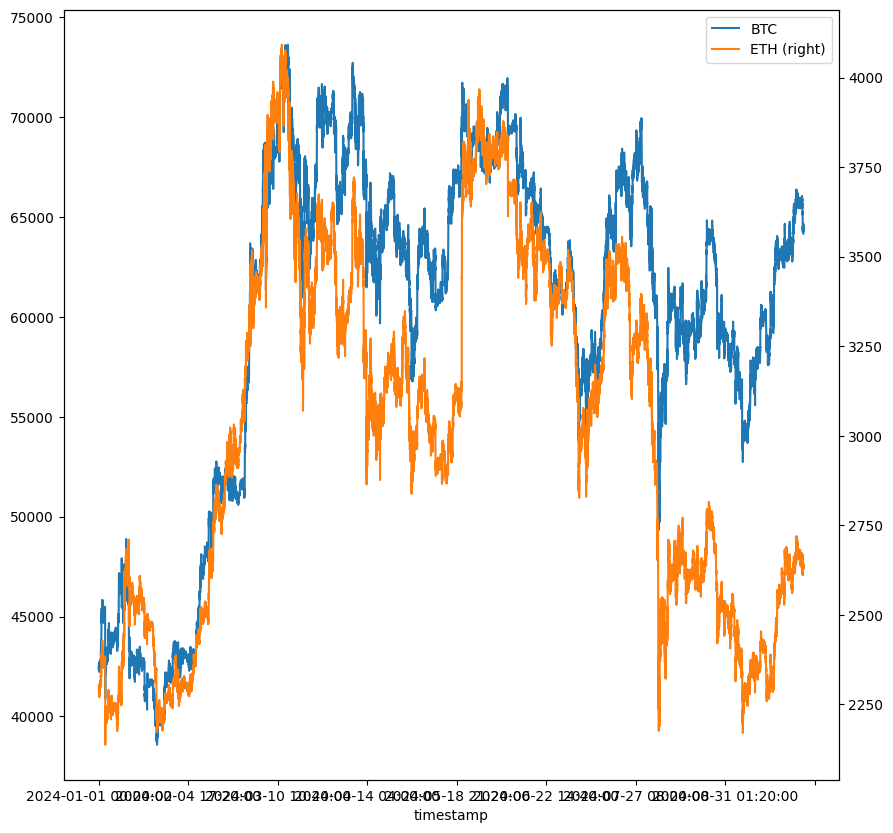

In [5]:
import pandas as pd
df_btc = pd.read_csv("data/BTC_USDT_5m.csv", sep=";")
df_eth = pd.read_csv("data/ETH_USDT_5m.csv", sep=";")

df_btc = df_btc.set_index("timestamp")
df_eth = df_eth.set_index("timestamp")

combined = pd.concat([df_btc["close"], df_eth["close"]], axis=1)
combined.columns = ["BTC", "ETH"]
combined = combined.dropna()

combined.plot(secondary_y="ETH", figsize=(10, 10))




<Axes: xlabel='timestamp'>

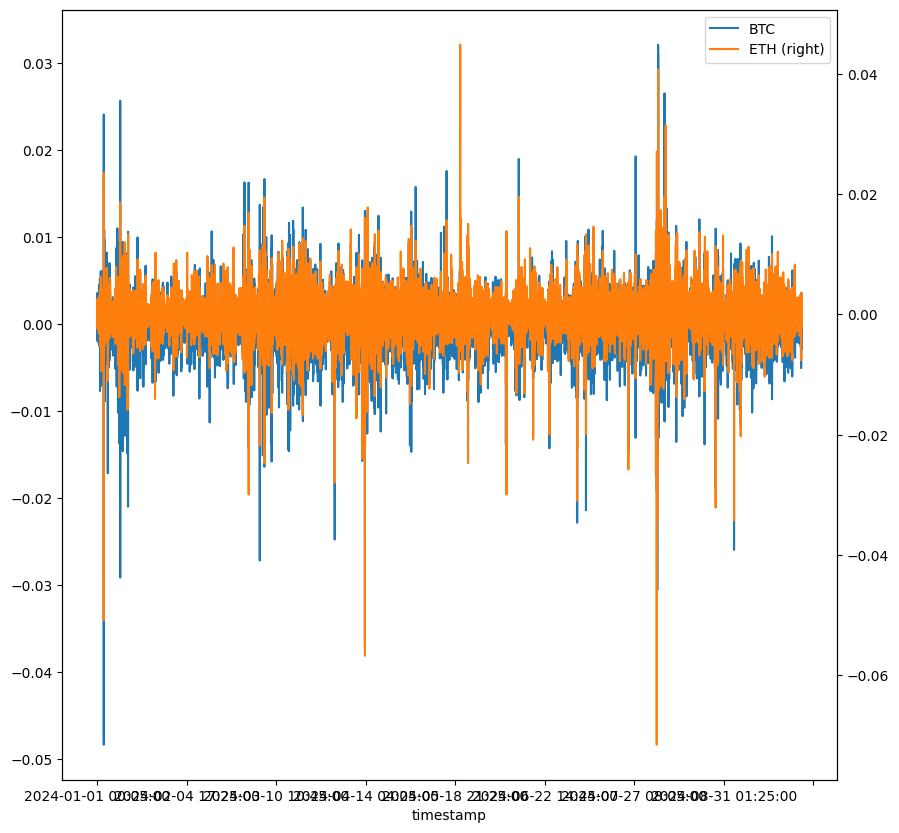

In [6]:
combined_pct = combined.pct_change().dropna()

combined_pct.plot(secondary_y="ETH", figsize=(10, 10))








In [7]:
combined_pct.corr()

,BTC,ETH
BTC,1.000000,0.840266
ETH,0.840266,1.000000


np.float64(-0.025034122641075185)

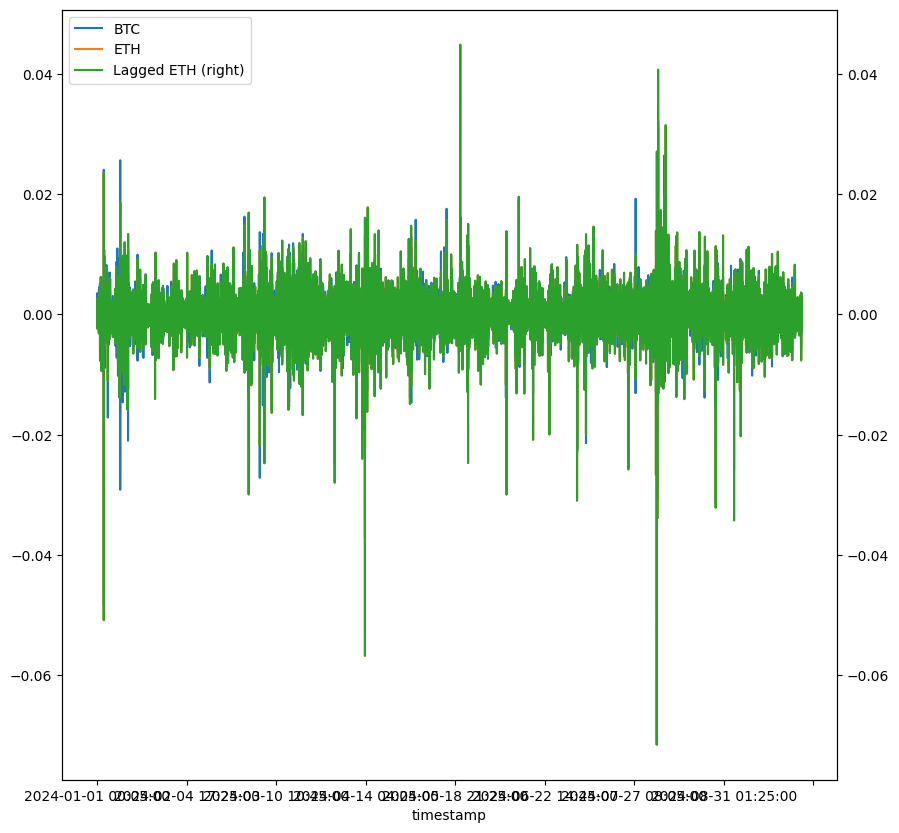

In [22]:
combined_pct["Lagged ETH"] = combined_pct["ETH"].shift(2)



combined_pct.plot(secondary_y="Lagged ETH", figsize=(10, 10))


combined_pct.corr().loc["BTC", "Lagged ETH"]












(78727, 3)

Notice that BTC and lagged ETH are negatively correlated.

The correlation is small though, so we can say that BTC and  lagged ETH are not very correlated.

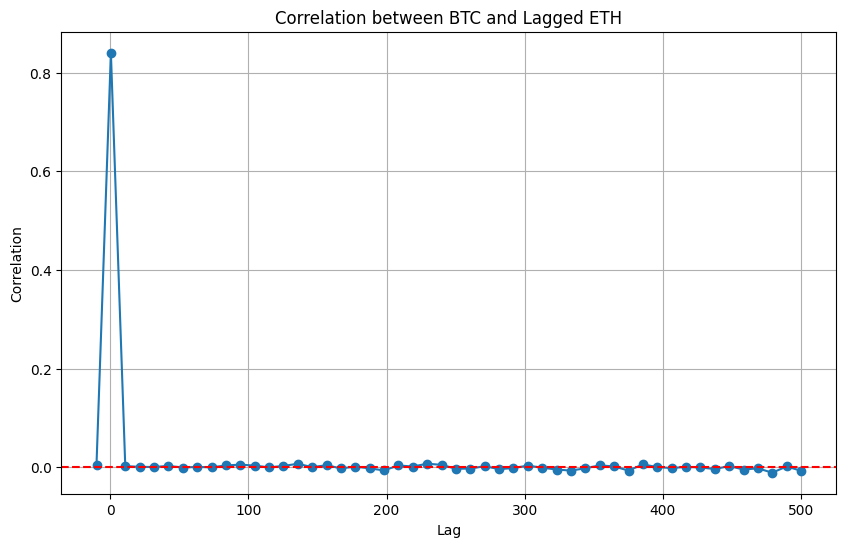

In [28]:
import numpy as np
import matplotlib.pyplot as plt

lags = np.linspace(-10, 500)
lagged_corrs = []

for lag in lags:
    combined_pct["Lagged ETH"] = combined_pct["ETH"].shift(int(lag))
    corr = combined_pct["BTC"].corr(combined_pct["Lagged ETH"])
    lagged_corrs.append(corr)

plt.figure(figsize=(10, 6))
plt.plot(lags, lagged_corrs, "-o")
plt.title("Correlation between BTC and Lagged ETH")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()


In [29]:
import statsmodels.tsa.stattools as ts


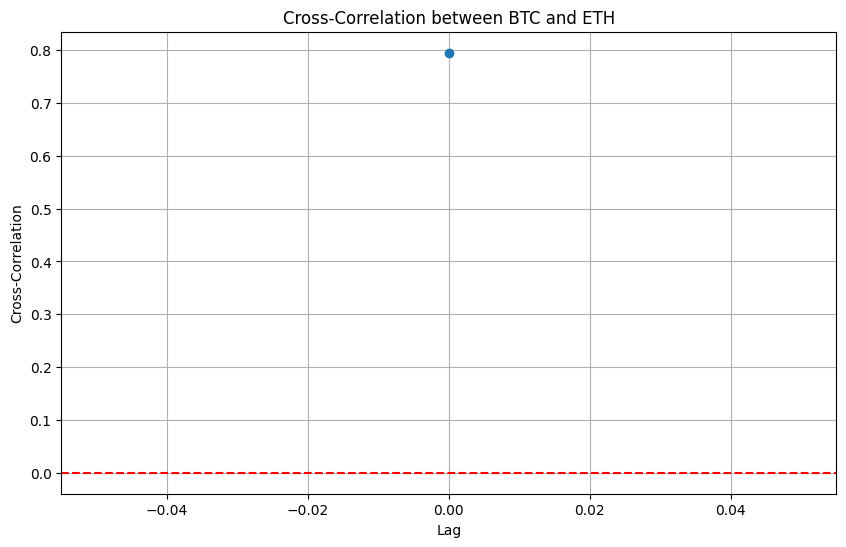

In [30]:
ccf = ts.ccf(combined['BTC'], combined['ETH'])

plt.figure(figsize=(10, 6))
plt.plot(ccf[0], "-o")
plt.title("Cross-Correlation between BTC and ETH")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

A good rule of thumb is that a correlation is significant if it is higher than 
 
$$
\frac{2}{\sqrt{n-|k|}}
$$

where $n$ is the number of observations and $k$ is the lag.





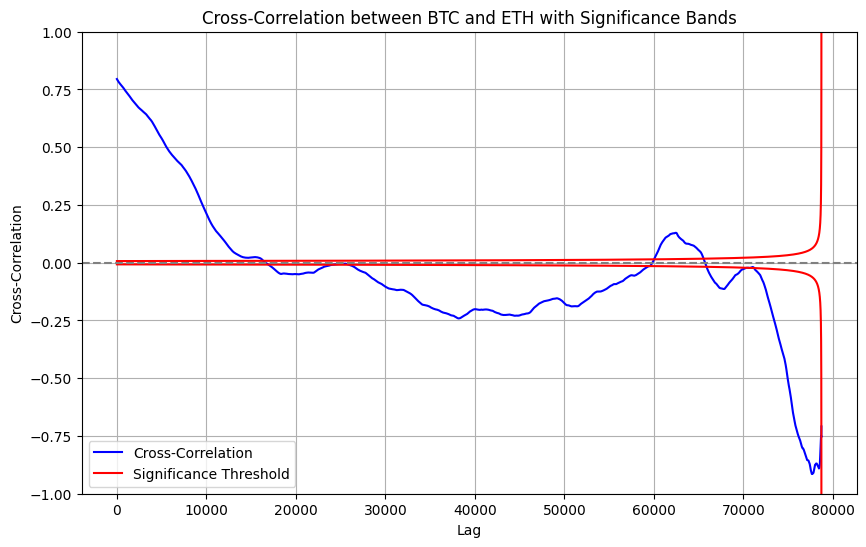

In [31]:
import numpy as np

n = len(combined)
x = np.arange(0, n)
threshold_positive = 2 / np.sqrt(n - x)
threshold_negative = -2 / np.sqrt(n - x)

plt.figure(figsize=(10, 6))
plt.plot(ccf, 'b', label='Cross-Correlation')
plt.plot(x, threshold_positive, 'r', label='Significance Threshold')
plt.plot(x, threshold_negative, 'r')
plt.title("Cross-Correlation between BTC and ETH with Significance Bands")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()


In [32]:
np.where(ccf > threshold_positive)[0]

array([    0,     1,     2, ..., 65573, 65574, 65575])

In [33]:
np.where(ccf < threshold_negative)[0]


array([16894, 16895, 16896, ..., 78718, 78719, 78720])

# 2. Autocorrelation

Autocorrelation is the rate at which a series of data (usually time series) correlates with itself (specifically, itself with lag). An example of this is a time series where one value is dependent on the previous version:

$$
y_t = 0.5 y_{t-1} + \epsilon_t
$$

where $\epsilon_t$ is white noise.







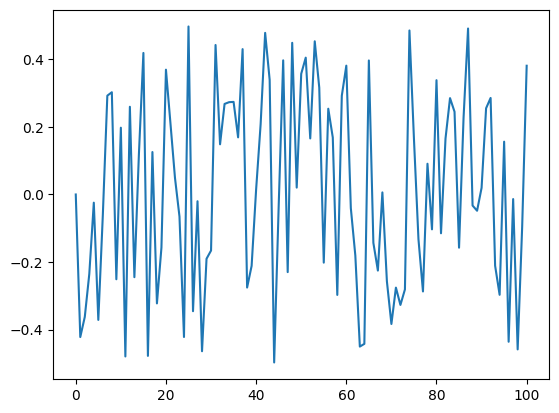

In [35]:
# Here is a completely random series, it should not depend on itself, and therefore should not have any autocorrelation
random_values = [0]

for i in range(100):
    # Just a random value
    random_values.append(np.random.random() - 0.5)

plt.plot(random_values)

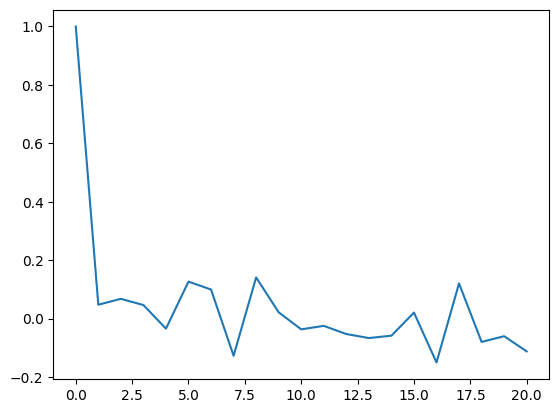

In [36]:
plt.plot(ts.acf(random_values))


In the above plot, we see the values correlate with itself with no lag - unsurprisingly.

However, after this, any other lag value has a near-zero correlation, indicating no correlation between the values and the lagged version.

Let's now create a time series with dependency.

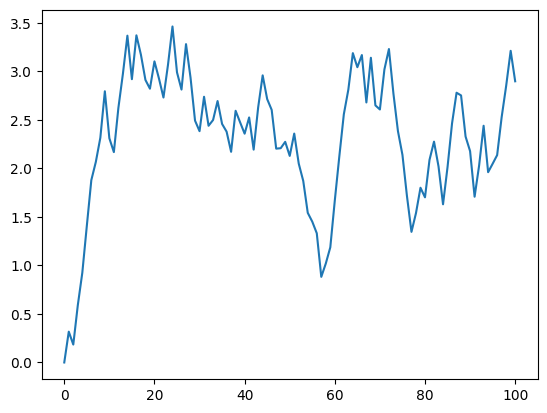

In [39]:
# Here is an example where value (n) is dependent on value (n-1)
values = [0]

for i in range(100):
    # Add a random value to the previous value. While the values are random, they are random, but biased
    values.append(np.random.random() - 0.5 + values[-1])

plt.plot(values)







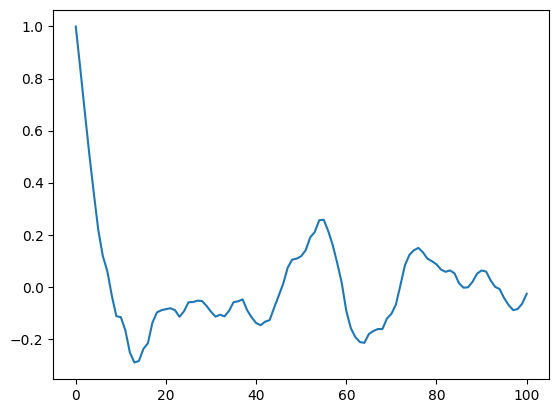

In [41]:
plt.plot(ts.acf(values, nlags=100))

In this example, the values are correlated with itself (as per the definition of correlation), but the correlation stays high as the lag increases. This shows that the values are dependent on themselves.

If your data is autocorrelated, you should remove this before computing cross correlation with other time series. You can remove autocorrelation with a process known as pre-whitening, which removes the autocorrelation.

An example of a method for this is **Holt Winters**. Techniques like this are also known as smoothing algorithms, but that term has multiple meanings, and smoothing algorithms have multiple uses.

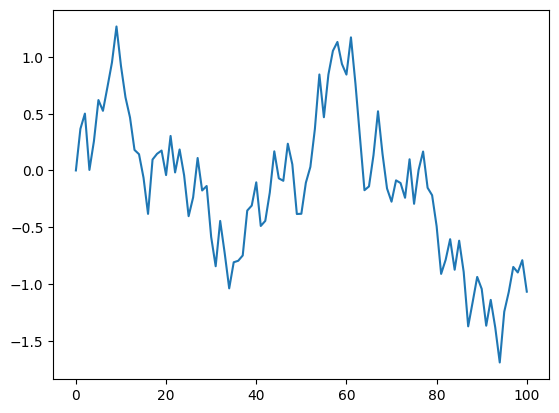

In [42]:
# Here is an example where value (n) is dependent on value (n-1)
values = [0]

for i in range(100):
    # Add a random value to the previous value. While the values are random, they are random, but biased
    values.append(np.random.random() - 0.5 + values[-1])

plt.plot(values)

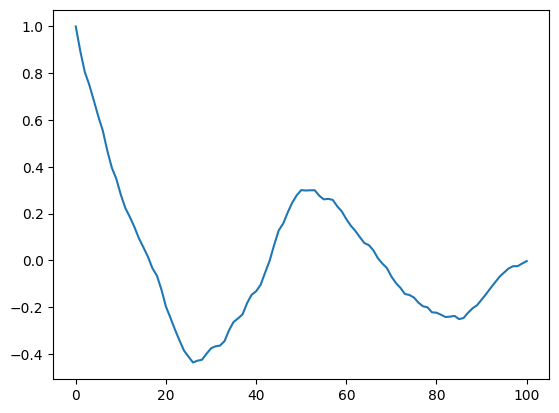

In [44]:
plt.plot(ts.acf(values, nlags=100))

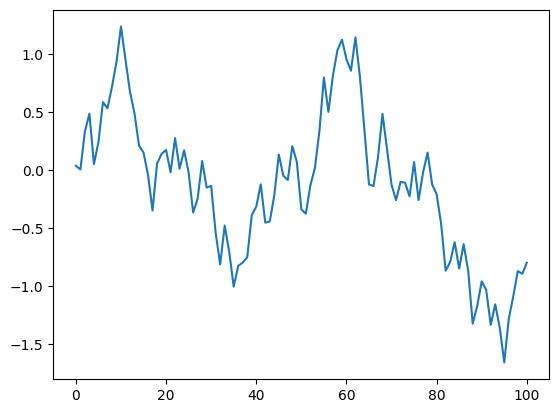

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(values)
model_fit = model.fit()

plt.plot(model_fit.fittedvalues)



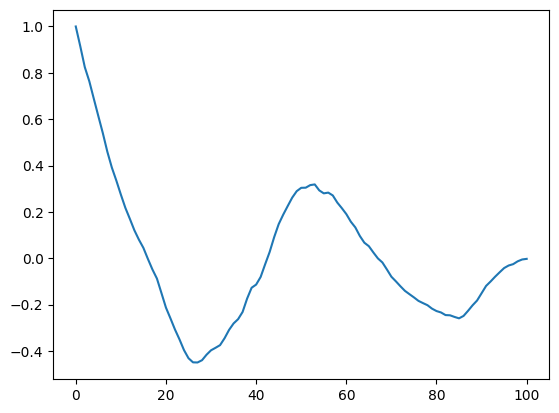

In [48]:
plt.plot(ts.acf(model_fit.fittedvalues, nlags=100))

##